# Projection

$V(\mathbf{r}) \rightarrow \tilde{V}(\mathbf{k}) \rightarrow \{ \tilde{V}_{p}^{(R)}(\mathbf{k}_{p}) =  \tilde{V}(R(\mathbf{k}_{p},0)) \}_{R} \rightarrow \{ V_{p}^{(R)}(r_{p}) \}_{R} $

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import mdtraj
import ipyvolume as ipv
from scipy.stats import special_ortho_group
import scipy.spatial
from scipy.spatial.transform import Rotation as R

## Build volume

Load atomic coordinates from a PDB file, discard a bunch of them, and assign a radius of 10A to the remaining ones.

In [2]:
coords = mdtraj.load('./material/simple_data/3pqr.pdb').xyz[0,::100,...]*10
radius = 10*np.ones(coords.shape[0])

Define image/volume size: `L` is length in Angstroem, `nx` is number of pixel per side

In [9]:
L  = 150
nx = 32

Initialize the grid. `volume` is the 3D density grid corresponding to centered `crds`

In [10]:
volume, crds = init_volume(nx, L, crds=coords, rad=radius)

Let's have a quick pick at that volume

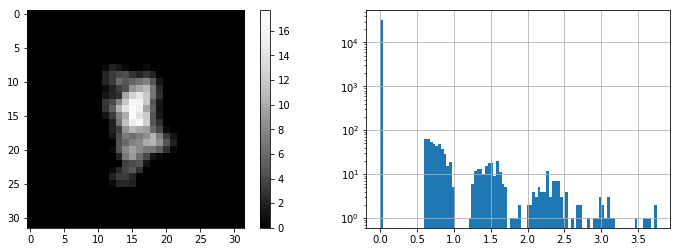

In [11]:
show_volume(volume, mode='sum', axis='Z')

Fourier transform the volume, compute the power spectrum density

In [12]:
volume_fourier = fft_volume(volume, shift=True)
volume_psd     = get_psd(volume_fourier)

Let's have a quick pick at that PSD

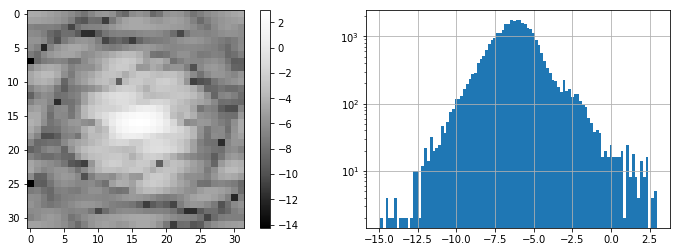

In [13]:
show_volume(volume_psd, mode='slice', axis='Z')

## Project the volume
`slices` are 2D objects in Fourier space, `projections` are their transform in real space.

In [14]:
ft_volume  = fft_volume(volume, shift=False)
projection = slice_to_projection(ft_volume[:,:,0])

no rotation yet, let's just take a look at the projection:

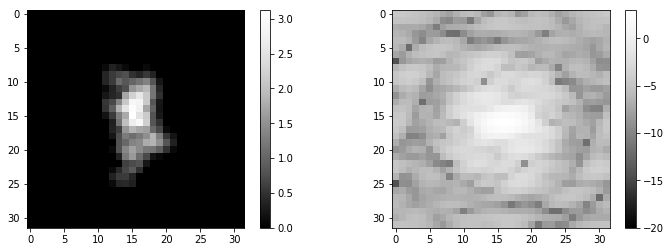

In [15]:
show_projection(projection)

build array of wavevectors on the plane of unrotated projection:

In [16]:
kplane = build_kplane(nx)

build (random) rotation matrix

In [72]:
rotmat = build_rotmat(mode='y', angle=270)

[[-2.22044605e-16  0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00 -2.22044605e-16]]


rotate wavevector. For now, we just pick the closest voxel. To be refined later...

In [73]:
k_new, mask = build_rotated_disk(kplane, rotmat)

In [74]:
new_slice = get_slice(ft_volume, k_new, mask)

In [75]:
new_projection = slice_to_projection(new_slice)

/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


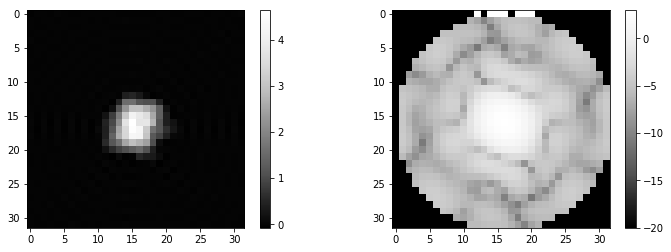

In [76]:
show_projection(new_projection)

plot initial and rotated wavevectors

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(kplane[:,0], kplane[:,1], kplane[:,2], marker='.')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(k_new[:,0], k_new[:,1], k_new[:,2], marker='.')
plt.tight_layout()
plt.show()

In [ ]:
for elt in np.arange(k_new.shape[0]):
    for idx in np.arange(3):
        k_new[elt,idx] += int(nx/2)

# Toolkit

In [71]:
# PROJECTION RELATED FUNCTIONS

def get_slice(volume, kslice, mask=None):
    """get_slice
    """
    if mask is None:
        mask = np.ones(kslice.shape[0], dtype=bool)
    nx = volume.shape[0]
    slice = np.zeros((nx,nx)).astype(complex)
    k=0
    for i in np.arange(nx):
        for j in np.arange(nx):
            if mask[k]:
                slice[i,j] = volume[kslice[k,0],kslice[k,1],kslice[k,2]]
            k+=1
    return slice

def build_rotmat(mode='identity', angle=0.0):
    if(mode=='random'):
        rotmat = special_ortho_group.rvs(3)
    elif(mode=='identity'):
        rotmat = np.identity(3)
    else:
        rotmat = R.from_euler(mode, angle, degrees=True).as_dcm()
    print(rotmat)
    return rotmat
    
def build_rotated_disk(kp, rotmat): #np.dot(kp,rotmat).astype('int')
    radius = np.int(np.sqrt(kp.shape[0])/2)
    krot = np.dot(kp,rotmat)
    knorm = np.linalg.norm(krot, axis=1)
    mask = knorm < radius
    return krot.astype('int'), mask

def build_kplane(nx):
    kp = np.zeros((nx*nx,3))
    k=0
    for i in np.arange(nx):
        if(i >= int(nx/2)):
            ix = i - nx
        else:
            ix = i
        for j in np.arange(nx):
            if(j >= int(nx/2)):
                jy = j - nx
            else:
                jy = j
            kp[k,0] = ix #- int(nx/2)
            kp[k,1] = jy #- int(nx/2)
            kp[k,2] = 0
            k+=1
    return kp
        
def slice_to_projection(ft_slice):
    return np.real(np.fft.ifft2(ft_slice, norm='ortho'))

In [6]:
# VOLUME HANDLING FUNCTIONS

def init_volume(n, L, crds=None, rad=None):
    # initialize grid
    volume = np.zeros((n,n,n))
    if crds is not None:
        # recenter
        crds = crds - np.mean(crds, axis=0)
        volume = grid_density(volume, L, crds=crds, rad=rad)
    return volume, crds
            
def grid_density(volume, L, crds=None, rad=None):
    if crds is not None:
        for i in np.arange(volume.shape[0]):
            posx = -L/2 + i*L/(volume.shape[0]-1)
            for j in np.arange(volume.shape[1]):
                posy = -L/2 + j*L/(volume.shape[1]-1)
                for k in np.arange(volume.shape[2]):
                    posz = -L/2 + k*L/(volume.shape[2]-1)
                    for iat in np.arange(crds.shape[0]):
                        dx = crds[iat,0] - posx
                        dy = crds[iat,1] - posy
                        dz = crds[iat,2] - posz
                        dist2 = dx*dx + dy*dy + dz*dz
                        if(dist2 <= 100):
                            rad2  = rad[iat]**2
                            density = np.exp(-0.5*dist2/rad2)
                            volume[i,j,k] += density
                            #print(i,j,k,posx, posy, posz,volume[i,j,k])
    return volume

def fft_volume(volume, shift=False):
    fourier_transform = np.fft.fftn(volume, norm='ortho')
    if shift:
        n = volume.shape[0]
        ft_slice  = np.fft.fftshift(fourier_transform[int(n/2),:,:])
        ft_vol    = np.expand_dims(ft_slice, axis=0)
        for i in np.arange(1,n):
            if(i<n/2):
                j=i+n/2
            else:
                j=i-n/2
            ft_slice  = np.fft.fftshift(fourier_transform[int(j),:,:])
            ft_vol    = np.append(ft_vol,[ft_slice[:,:]],axis=0)
    else:
        ft_vol = fourier_transform
    return np.array(ft_vol)

def get_psd(ft_array):
    """get_psd
    also works on 2D images
    """
    return np.log(np.abs((ft_array))**2)

In [7]:
# PLOTTING FUNCTIONS

def show_volume(volume, mode='sum', axis='Z', bins=100):
    fig = plt.figure(figsize=(12,4))
    plt.subplot(121)
    display_volume(volume, mode=mode, axis=axis, dimension=2)
    plt.subplot(122)
    display_hist(volume.flatten(), bins=bins)
    plt.show()

def show_projection(projection, cmap='Greys_r'):
    fig = plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.imshow(projection, cmap=cmap)
    plt.colorbar()
    plt.subplot(122)
    slice = np.fft.fft2(projection, norm='ortho')
    psd   = get_psd(np.fft.fftshift(slice))
    plt.imshow(psd, cmap=cmap, vmin=-20)
    plt.colorbar()
    
def display_volume(volume, mode='sum', axis='Z', dimension=2, cmap='Greys_r'):
    #display_dimension = 2
    nx = volume.shape[0]
    if(dimension < 3):
        if(mode=='sum'):
            if(axis=='X'):
                numaxis=0
            elif(axis=='Y'):
                numaxis=1
            elif(axis=='Z'):
                numaxis=2
            plt.imshow(np.sum(volume,axis=numaxis), cmap=cmap)
        elif(mode=='slice'):
            if(axis=='X'):
                plt.imshow(volume[int(nx/2),...], cmap=cmap)
            elif(axis=='Y'):
                plt.imshow(volume[:,int(nx/2),:], cmap=cmap)
            elif(axis=='Z'):
                plt.imshow(volume[:,:,int(nx/2)], cmap=cmap)
        plt.colorbar()
    else:
        ipv.quickvolshow(volume, level=[0.1, 0.1], opacity=0.1)
        
def display_hist(volume, bins=10):
    plt.hist(volume, bins=bins, log=True)
    plt.grid()
    plt.show()